-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "PM_US Post"
DATA = "all"  # "all" or "part"
THRESHOLD_LIST = [2]  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

-----------
### データの前処理

In [3]:
df_Beijing = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\中国気象データ\BeijingPM20100101_20151231.csv"
)
df_Chengdu = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\中国気象データ\ChengduPM20100101_20151231.csv"
)
df_Guangzhou = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\中国気象データ\GuangzhouPM20100101_20151231.csv"
)
df_Shanghai = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\中国気象データ\ShanghaiPM20100101_20151231.csv"
)
df_Shenyang = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\中国気象データ\ShenyangPM20100101_20151231.csv"
)

if DATA == "all":
    df_all = pd.concat(
        [df_Beijing, df_Chengdu, df_Guangzhou, df_Shanghai, df_Shenyang],
        axis=0,
        ignore_index=True,
    )
if DATA == "part":
    df_all = df_Beijing

features_list = [
    "DEWP",
    "TEMP",
    "HUMI",
    "PRES",
    "Iws",
    "precipitation",
    "Iprec",
]

variables_list = [
    "PM_US Post",
    "DEWP",
    "TEMP",
    "HUMI",
    "PRES",
    "Iws",
    "precipitation",
    "Iprec",
]

df_2014 = df_all[df_all["year"] == 2014][variables_list]
df_2015 = df_all[df_all["year"] == 2015][variables_list]
print(df_2014)
print(df_2015)

        PM_US Post  DEWP  TEMP   HUMI    PRES     Iws  precipitation  Iprec
35064         53.0 -20.0   7.0  12.00  1014.0  143.48            0.0    0.0
35065         65.0 -20.0   7.0  12.00  1013.0  147.50            0.0    0.0
35066         70.0 -20.0   6.0  13.00  1013.0  151.52            0.0    0.0
35067         79.0 -20.0   6.0  13.00  1013.0  153.31            0.0    0.0
35068         92.0 -18.0   3.0  19.00  1012.0    0.89            0.0    0.0
...            ...   ...   ...    ...     ...     ...            ...    ...
254155        38.0 -20.0 -10.0  43.68  1026.0   51.00            0.0    0.0
254156        36.0 -21.0 -10.0  40.04  1026.0   55.00            0.0    0.0
254157        31.0 -21.0 -11.0  43.36  1027.0   59.00            0.0    0.0
254158        30.0 -21.0 -11.0  43.36  1027.0   64.00            0.0    0.0
254159        26.0 -21.0 -12.0  46.98  1027.0   68.00            0.0    0.0

[43800 rows x 8 columns]
        PM_US Post  DEWP  TEMP   HUMI    PRES    Iws  precipit

欠損値除去

In [4]:
def remove_nan(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 各列に対して、pd.to_numericを使用して数値に変換（エラーがあればNaNにする）
    df_numeric = data.apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # 数値に変換できなかった行を抽出（NaNを含む行）
    df_excluded = data[df_numeric.isna().any(axis=1)]

    # NaNを含む行を削除
    df_clean = df_numeric.dropna()

    return df_excluded, df_clean

In [5]:
df_2014_ex, df_2014_clean = remove_nan(df_2014)
df_2015_ex, df_2015_clean = remove_nan(df_2015)
print(df_2014_ex)
print(df_2014_clean)
print()
print(df_2015_ex)
print(df_2015_clean)

        PM_US Post  DEWP  TEMP   HUMI    PRES    Iws  precipitation  Iprec
35328          NaN -22.0   1.0  16.00  1032.0   8.94            0.0    0.0
35329          NaN -21.0  -1.0  20.00  1033.0  16.09            0.0    0.0
35330          NaN -24.0  -1.0  15.00  1034.0  24.14            0.0    0.0
35331          NaN -22.0  -3.0  21.00  1035.0  29.95            0.0    0.0
35332          NaN -23.0  -6.0  24.00  1035.0  33.97            0.0    0.0
...            ...   ...   ...    ...     ...    ...            ...    ...
253619       185.0 -14.0  -4.0  45.60  1036.0  16.00            NaN    NaN
253624        33.0 -15.0   0.0  31.25  1031.0  12.00            NaN    NaN
253669        82.0 -17.0 -10.0  56.45  1030.0   1.00            NaN    NaN
253760         NaN -15.0 -11.0  72.23  1025.0  31.00            0.0    0.0
253812        26.0 -23.0 -14.0  46.33  1030.0   4.00            NaN    NaN

[3466 rows x 8 columns]
        PM_US Post  DEWP  TEMP   HUMI    PRES     Iws  precipitation  Iprec

-------------
### 外れ値を除外しない場合

In [6]:
df = df_2014_clean

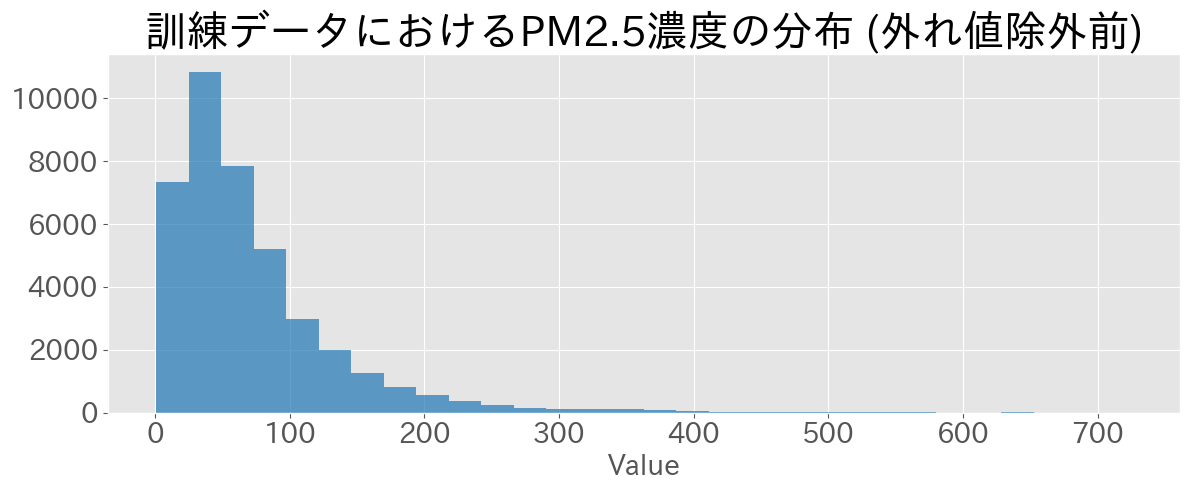

In [7]:
y = df[TARGET]

fig, axes = plt.subplots(1, 1, figsize=(12, 5))
axes.hist(
    y,
    bins=30,
    color="#1f77b4",
    alpha=0.7,
)
axes.set_title("訓練データにおけるPM2.5濃度の分布 (外れ値除外前)", fontsize=30)
axes.set_xlabel("Value", fontsize=20)
axes.tick_params(axis="both", labelsize=20)

plt.tight_layout()
plt.show()

-------------
### 外れ値除外

In [8]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

閾値：2
外れ値除外前のデータ数（訓練+テスト）: 40334
外れ値除外後のデータ数（訓練+テスト）: 38559
除外されたデータ数： 1775
分散:  1828.1901156692338


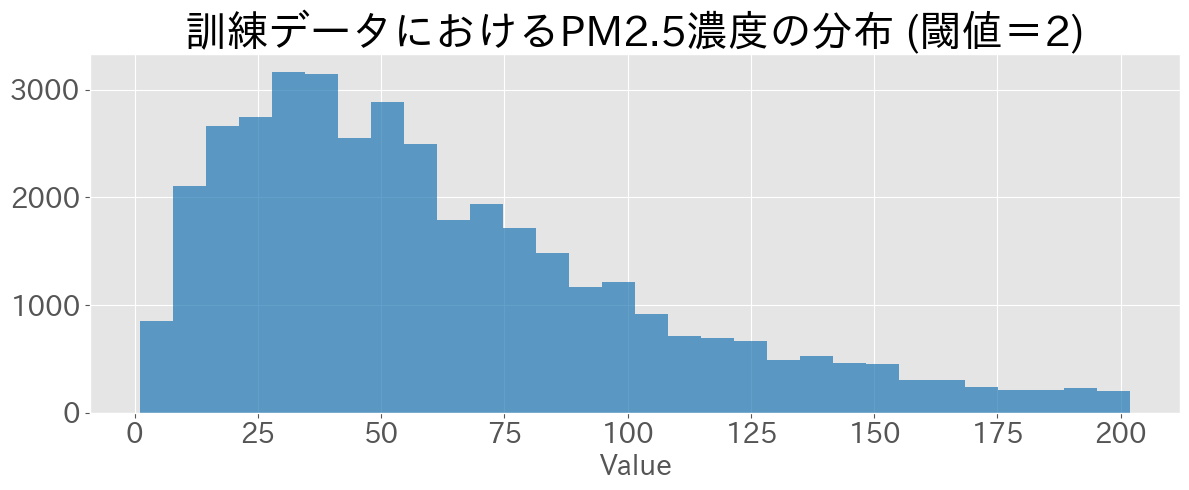

In [9]:
for i in range(len(THRESHOLD_LIST)):
    df_outliers_removed = remove_outliers_zscore(
        data=df, metric=TARGET, threshold=THRESHOLD_LIST[i]
    )
    df_outliers_removed = df_outliers_removed.reset_index(drop=True)  # 行を詰める
    y = df_outliers_removed[TARGET]
    print(f"閾値：{THRESHOLD_LIST[i]}")
    print("外れ値除外前のデータ数（訓練+テスト）:", len(df_2014_clean))
    print("外れ値除外後のデータ数（訓練+テスト）:", len(df_outliers_removed))
    print("除外されたデータ数：", len(df_2014_clean) - len(df_outliers_removed))
    print("分散: ", np.var(y))
    fig, axes = plt.subplots(1, 1, figsize=(12, 5))
    axes.hist(
        y,
        bins=30,
        color="#1f77b4",
        alpha=0.7,
    )
    axes.set_title(
        f"訓練データにおけるPM2.5濃度の分布 (閾値＝{THRESHOLD_LIST[i]})", fontsize=30
    )
    axes.set_xlabel("Value", fontsize=20)
    axes.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()